# **Exoplanet Habitability**

### Jordan Sinclair

This notebook is an experiment in classifying exoplanets as habitable or not from various mission data. 

## **Notebook Setup**

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

Drive not mounted, so nothing to flush and unmount.
All changes made in this colab session should now be visible in Drive.


In [1]:
google_drive_root='/Portfolio Projects/Classifying Exoplanets/Habitability'

In [2]:
google_drive_mount_location = '/content/drive'
google_file_prefix=google_drive_mount_location + '/My Drive/' + google_drive_root + '/'

In [3]:
from google.colab import drive
drive.mount(google_drive_mount_location)

Mounted at /content/drive


## **Imports**

In [43]:
# imports

#Data
import pandas as pd
import numpy as np

#Machine Learning Utilities
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

#Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

#Plotting:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## **Getting the Data**

The following line reads in an exoplanet dataset from Kaggle. The link to the dataset is below. 

https://www.kaggle.com/datasets/chandrimad31/phl-exoplanet-catalog

In [5]:
data = google_file_prefix + 'phl_exoplanet_catalog_2019.csv' #Location of data in drive

In [6]:
#Reads data into pandas dataframe 
df = pd.read_csv(data)
df.head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66


## **Preprocessing**

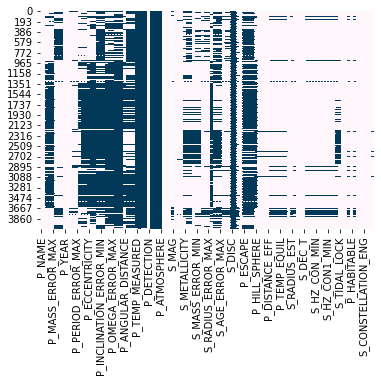

In [8]:
sns.heatmap(df.isnull(), cbar=False, cmap='PuBu') #Plots a heatmap of the missing values in the dataset

In [9]:
#Sorts the rows by how many null values they have. 
nullVals = df.isnull().mean().sort_values(ascending=False)
nullVals.head(50)

P_DETECTION_MASS                1.000000
P_GEO_ALBEDO                    1.000000
S_MAGNETIC_FIELD                1.000000
S_DISC                          1.000000
P_ATMOSPHERE                    1.000000
P_ALT_NAMES                     1.000000
P_DETECTION_RADIUS              1.000000
P_GEO_ALBEDO_ERROR_MIN          0.998765
P_TEMP_MEASURED                 0.998765
P_GEO_ALBEDO_ERROR_MAX          0.998765
P_TPERI_ERROR_MAX               0.883399
P_TPERI_ERROR_MIN               0.883399
P_TPERI                         0.881176
P_OMEGA_ERROR_MIN               0.828804
P_OMEGA_ERROR_MAX               0.828804
P_DENSITY                       0.825593
P_ESCAPE                        0.825593
P_POTENTIAL                     0.825593
P_GRAVITY                       0.825593
P_OMEGA                         0.815711
P_INCLINATION_ERROR_MAX         0.799901
P_INCLINATION_ERROR_MIN         0.799407
P_INCLINATION                   0.791502
P_ECCENTRICITY_ERROR_MAX        0.760128
P_ECCENTRICITY_E

In [10]:
#Drops rows with unnecessary info or a lot of missing values. 
df = df.drop(["P_DETECTION_MASS", "P_GEO_ALBEDO", "S_MAGNETIC_FIELD", "S_DISC", "P_ATMOSPHERE", "P_ALT_NAMES", "P_DETECTION_RADIUS", "P_GEO_ALBEDO_ERROR_MIN", "P_TEMP_MEASURED", "P_GEO_ALBEDO_ERROR_MAX",
              "P_TPERI_ERROR_MAX", "P_TPERI_ERROR_MIN", "P_TPERI", "P_OMEGA_ERROR_MIN", "P_OMEGA_ERROR_MAX", "P_DENSITY", "P_ESCAPE", "P_POTENTIAL", "P_GRAVITY", "P_OMEGA",
              "P_INCLINATION_ERROR_MAX", "P_INCLINATION_ERROR_MIN", "P_INCLINATION", "P_ECCENTRICITY_ERROR_MAX", "P_ECCENTRICITY_ERROR_MIN", "S_TYPE", "P_ECCENTRICITY",
              "P_IMPACT_PARAMETER_ERROR_MIN", "P_IMPACT_PARAMETER_ERROR_MAX", "P_IMPACT_PARAMETER", "P_MASS_ERROR_MAX", "P_MASS_ERROR_MIN", "P_HILL_SPHERE", 
              "P_SEMI_MAJOR_AXIS_ERROR_MIN", "P_SEMI_MAJOR_AXIS_ERROR_MAX", "P_MASS"], axis=1)

In [11]:
df.head()

,P_NAME,P_STATUS,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,NaN,NaN,NaN,2007,2014-05-14,326.03000,-0.32,0.32,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29
1,11 UMi b,3.0,NaN,NaN,NaN,2009,2018-09-06,516.21997,-3.20,3.20,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53
2,14 And b,3.0,NaN,NaN,NaN,2008,2014-05-14,185.84000,-0.23,0.23,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83
3,14 Her b,3.0,NaN,NaN,NaN,2002,2018-09-06,1773.40000,-2.50,2.50,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93
4,16 Cyg B b,3.0,NaN,NaN,NaN,1996,2018-09-06,798.50000,-1.00,1.00,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66


In [12]:
#Sums the missing values for each of the noninteger columns. 
df.select_dtypes(include=['object']).isnull().sum()

P_NAME                   0
P_UPDATED                0
P_DETECTION              0
S_NAME                   0
S_ALT_NAMES              0
P_TYPE                  17
S_TYPE_TEMP            136
S_RA_T                   0
S_DEC_T                  0
P_TYPE_TEMP            327
S_CONSTELLATION          0
S_CONSTELLATION_ABR      0
S_CONSTELLATION_ENG      0
dtype: int64

In [14]:
df["P_TYPE"].value_counts()

Jovian         1319
Superterran    1099
Neptunian       898
Terran          673
Subterran        58
Miniterran        1
Name: P_TYPE, dtype: int64

In [13]:
#Imputes the categorical missing values with the mode of the column
df["P_TYPE"] = df["P_TYPE"].fillna(df["P_TYPE"].mode()[0])
df["P_TYPE_TEMP"] = df["P_TYPE_TEMP"].fillna(df["P_TYPE_TEMP"].mode()[0])
df["S_TYPE_TEMP"] = df["S_TYPE_TEMP"].fillna(df["S_TYPE_TEMP"].mode()[0])

In [15]:
df.head()

,P_NAME,P_STATUS,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,NaN,NaN,NaN,2007,2014-05-14,326.03000,-0.32,0.32,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29
1,11 UMi b,3.0,NaN,NaN,NaN,2009,2018-09-06,516.21997,-3.20,3.20,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53
2,14 And b,3.0,NaN,NaN,NaN,2008,2014-05-14,185.84000,-0.23,0.23,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83
3,14 Her b,3.0,NaN,NaN,NaN,2002,2018-09-06,1773.40000,-2.50,2.50,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93
4,16 Cyg B b,3.0,NaN,NaN,NaN,1996,2018-09-06,798.50000,-1.00,1.00,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66


In [17]:
#Uses label encoder to encode each of the categorical columns as integers. Each original label is mapped to a number. 
lencoders = {}
for col in df.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    df[col] = lencoders[col].fit_transform(df[col])

In [18]:
df.head()

,P_NAME,P_STATUS,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,0,3.0,NaN,NaN,NaN,2007,0,326.03000,-0.32,0.32,...,0,1,0,0.083813,24,24,5,12.082709,6165.86330,1.29
1,1,3.0,NaN,NaN,NaN,2009,146,516.21997,-3.20,3.20,...,0,1,0,0.082414,83,83,42,12.229641,4684.78480,1.53
2,2,3.0,NaN,NaN,NaN,2008,0,185.84000,-0.23,0.23,...,0,1,0,0.081917,0,0,2,12.848516,1525.57440,0.83
3,3,3.0,NaN,NaN,NaN,2002,146,1773.40000,-2.50,2.50,...,0,0,0,0.145241,39,39,34,12.865261,1481.07850,2.93
4,4,3.0,NaN,NaN,NaN,1996,146,798.50000,-1.00,1.00,...,1,2,0,0.368627,30,30,75,13.421749,565.73385,1.66


In [19]:
len(df["P_RADIUS"])

4048

In [20]:
df.isnull().sum().sort_values(ascending=False) #Addressing the remaining missing values

S_AGE_ERROR_MAX       2161
S_AGE_ERROR_MIN       2161
S_AGE                 2017
P_ANGULAR_DISTANCE    1687
P_SEMI_MAJOR_AXIS     1681
                      ... 
P_STATUS                 0
P_TYPE                   0
S_DEC_T                  0
S_RA_T                   0
P_NAME                   0
Length: 76, dtype: int64

In [22]:
imp = IterativeImputer(max_iter=10, verbose=0) #Creates an iterative imputer object
imp.fit(df) #Fits the imputer to the dataframe
imputed_df = imp.transform(df) #Transforms the data
df = pd.DataFrame(imputed_df, columns=df.columns) #Creates a dataframe from the imputed data. 

In [23]:
df.isna().sum().sort_values(ascending=False) #Double checks that there are no missing values

P_NAME                     0
S_RADIUS_EST               0
S_HZ_OPT_MAX               0
S_HZ_OPT_MIN               0
S_LUMINOSITY               0
                          ..
S_MASS_ERROR_MIN           0
S_MASS                     0
S_METALLICITY_ERROR_MAX    0
S_METALLICITY_ERROR_MIN    0
P_SEMI_MAJOR_AXIS_EST      0
Length: 76, dtype: int64

In [24]:
df.head()

,P_NAME,P_STATUS,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,0.0,3.0,4.798394,9.908788,-1.895067,2007.0,0.0,326.03000,-0.32,0.32,...,0.0,1.0,0.0,0.083813,24.0,24.0,5.0,12.082709,6165.86330,1.29
1,1.0,3.0,4.798394,9.908788,-1.895067,2009.0,146.0,516.21997,-3.20,3.20,...,0.0,1.0,0.0,0.082414,83.0,83.0,42.0,12.229641,4684.78480,1.53
2,2.0,3.0,4.798394,9.908788,-1.895067,2008.0,0.0,185.84000,-0.23,0.23,...,0.0,1.0,0.0,0.081917,0.0,0.0,2.0,12.848516,1525.57440,0.83
3,3.0,3.0,4.798394,9.908788,-1.895067,2002.0,146.0,1773.40000,-2.50,2.50,...,0.0,0.0,0.0,0.145241,39.0,39.0,34.0,12.865261,1481.07850,2.93
4,4.0,3.0,4.798394,9.908788,-1.895067,1996.0,146.0,798.50000,-1.00,1.00,...,1.0,2.0,0.0,0.368627,30.0,30.0,75.0,13.421749,565.73385,1.66


In [25]:
df["P_HABITABLE"].value_counts() #Checking the proportion of each class

0.0    3993
2.0      34
1.0      21
Name: P_HABITABLE, dtype: int64

In [27]:
#Handling class imbalance with SMOTE algorithm
seed = 100 #Creates a random seed 
k = 15 #Number of neighbors

X = df.loc[:, df.columns != "P_HABITABLE"] #Data
y = df["P_HABITABLE"] #Class label

smote = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed) #Creates a SMOTE object with designated paramaters above
X_res, y_res = smote.fit_resample(X, y) #Resamples the input data

df = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1) #Concatenates dataframe objects of the X and y data
df.head()

,P_NAME,P_STATUS,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,...,P_HABZONE_CON,P_TYPE_TEMP,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST,P_HABITABLE
0,0.0,3.0,4.798394,9.908788,-1.895067,2007.0,0.0,326.03000,-0.32,0.32,...,0.0,1.0,0.083813,24.0,24.0,5.0,12.082709,6165.86330,1.29,0.0
1,1.0,3.0,4.798394,9.908788,-1.895067,2009.0,146.0,516.21997,-3.20,3.20,...,0.0,1.0,0.082414,83.0,83.0,42.0,12.229641,4684.78480,1.53,0.0
2,2.0,3.0,4.798394,9.908788,-1.895067,2008.0,0.0,185.84000,-0.23,0.23,...,0.0,1.0,0.081917,0.0,0.0,2.0,12.848516,1525.57440,0.83,0.0
3,3.0,3.0,4.798394,9.908788,-1.895067,2002.0,146.0,1773.40000,-2.50,2.50,...,0.0,0.0,0.145241,39.0,39.0,34.0,12.865261,1481.07850,2.93,0.0
4,4.0,3.0,4.798394,9.908788,-1.895067,1996.0,146.0,798.50000,-1.00,1.00,...,1.0,2.0,0.368627,30.0,30.0,75.0,13.421749,565.73385,1.66,0.0


In [28]:
df["P_HABITABLE"].value_counts()

0.0    3993
2.0    3993
1.0    3993
Name: P_HABITABLE, dtype: int64

In [29]:
pal = sns.choose_diverging_palette() #Helper to create a fun color palette (:

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

<ipython-input-30-1646721c7090>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool)) #Mask


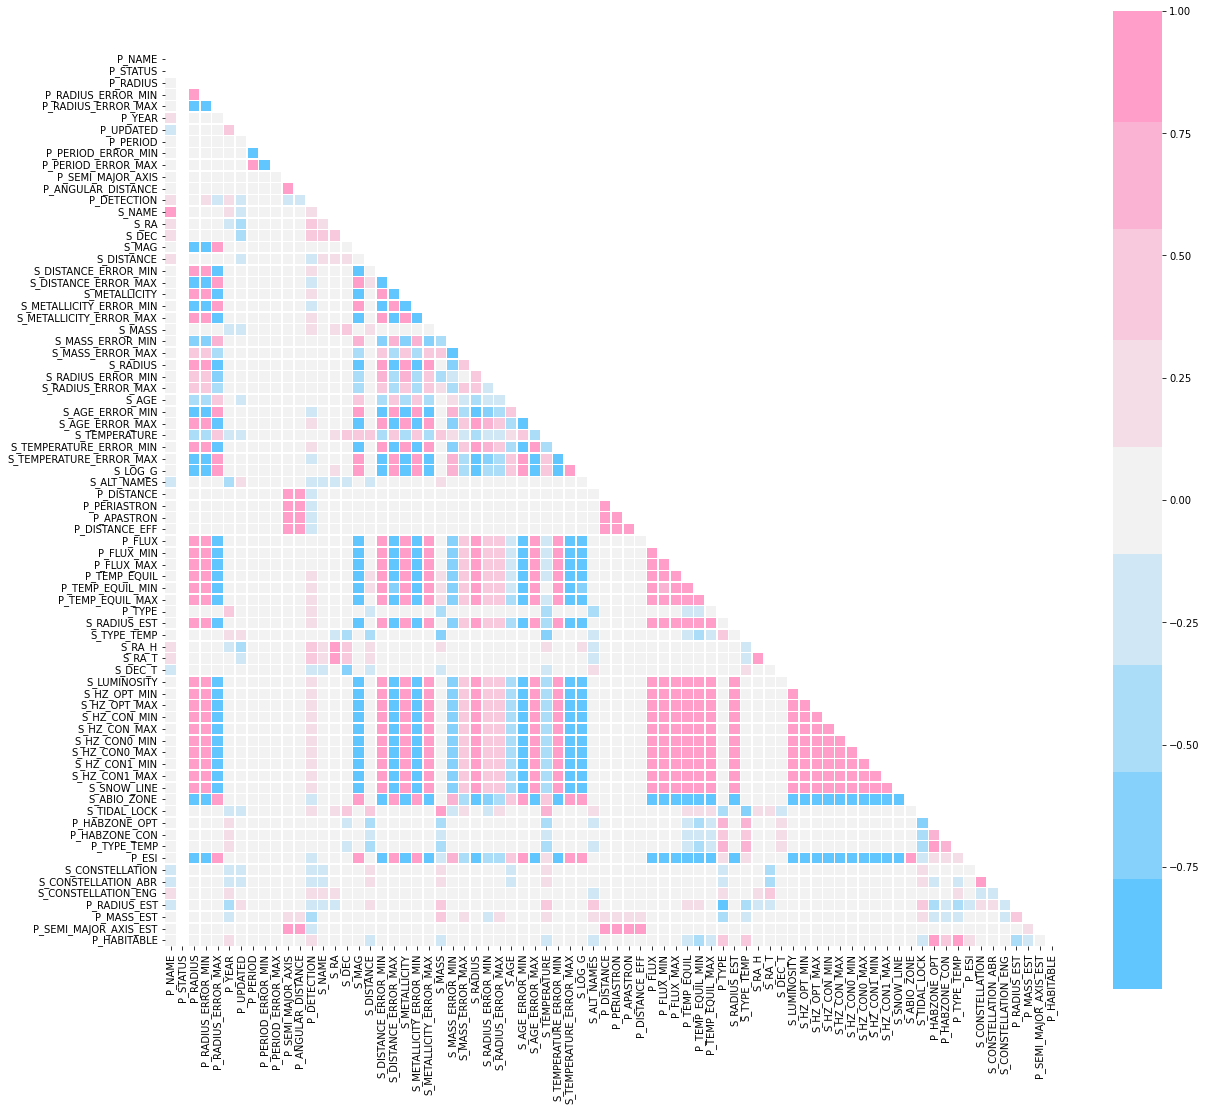

In [30]:
# Correlation Heatmap
corr = df.corr() #Creates a correlation object
mask = np.triu(np.ones_like(corr, dtype=np.bool)) #Mask
f, ax = plt.subplots(figsize=(20, 20))
#Plots a heatmap of the correlation between each feature column. 
#1 - highly correlated 
sns.heatmap(corr, mask=mask, cmap=pal, vmax=None, center=0,square=True, annot=False, linewidths=.5, cbar_kws={"shrink": 0.9})

In [31]:
#Drops one of each of the highly correlated pairs
working_data = df.drop(['S_NAME', 'P_RADIUS', 'P_RADIUS_ERROR_MIN', 'P_RADIUS_ERROR_MAX', 'P_DISTANCE', 'P_PERIASTRON', 'P_APASTRON', 
                                 'P_DISTANCE_EFF', 'P_FLUX_MIN', 'P_FLUX_MAX', 'P_TEMP_EQUIL', 'P_TEMP_EQUIL_MIN', 'P_TEMP_EQUIL_MAX', 
                                 'S_RADIUS_EST', 'S_RA_H', 'S_RA_T', 'S_LUMINOSITY', 'S_HZ_OPT_MIN', 'S_HZ_OPT_MAX', 'S_HZ_CON_MIN', 
                                 'S_HZ_CON_MAX', 'S_HZ_CON0_MIN', 'S_HZ_CON0_MAX', 'S_HZ_CON1_MIN', 'S_HZ_CON1_MAX', 'S_SNOW_LINE', 
                                'P_PERIOD_ERROR_MIN', 'P_PERIOD_ERROR_MAX', 'S_MAG', 'S_DISTANCE_ERROR_MIN', 'S_DISTANCE_ERROR_MAX', 
                                 'S_METALLICITY', 'S_METALLICITY_ERROR_MIN', 'S_METALLICITY_ERROR_MAX', 'S_AGE', 'S_TEMPERATURE_ERROR_MIN', 
                                 'S_TEMPERATURE_ERROR_MAX', 'S_ABIO_ZONE', 'P_ESI', 'S_CONSTELLATION_ABR', 'P_SEMI_MAJOR_AXIS_EST'], axis=1)

<ipython-input-33-7d12b0bb98ca>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


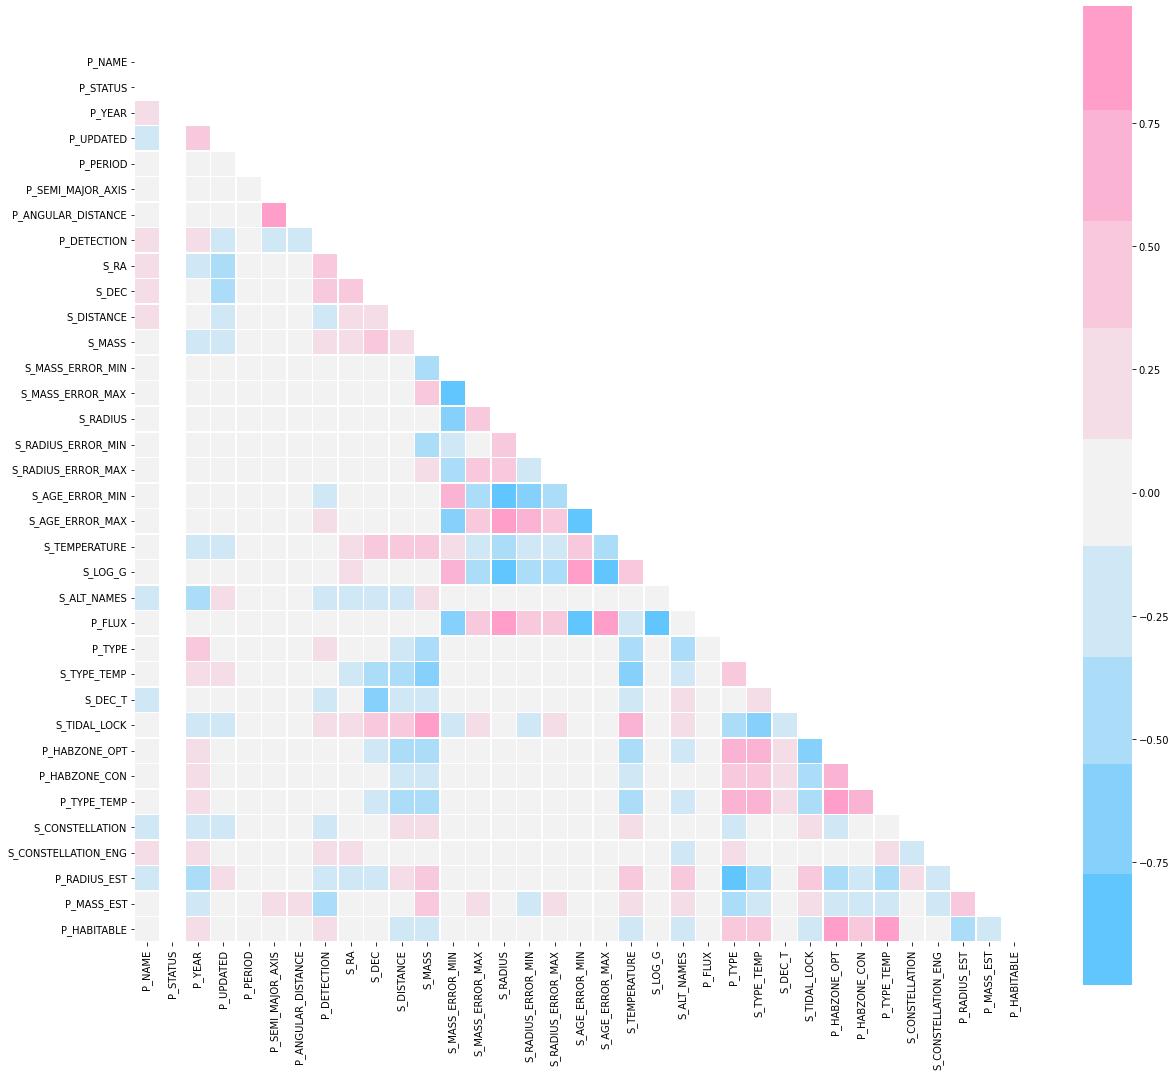

In [33]:
#Replots the correlation graph with the new dataframe. 
corr = working_data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap=pal, vmax=None, center=0,square=True, annot=False, linewidths=.5, cbar_kws={"shrink": 0.9})

In [34]:
working_data["P_STATUS"].value_counts() #I noticed P_Status only has one possible value...

3.0    11979
Name: P_STATUS, dtype: int64

In [35]:
working_data = working_data.drop("P_STATUS", axis=1) #So I decided to drop it as well before training. 

## **Splitting into Train/Test**

In [36]:
#Gets X (feature data) and y (class label) data 
X = working_data.loc[:, working_data.columns != "P_HABITABLE"]
y = working_data["P_HABITABLE"]

#Uses train_test_split to split the data into a training and testing set with a 25% of the data going to the latter. 
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.25, 
                     random_state=1)
#Prints the ratio of training to testing data. 
print("Training/testing: ", len(X_train), "/", len(X_test))

Training/testing:  8984 / 2995


In [37]:
y_train.value_counts("P_HABITABLE") #Checks that the classes are still balanced. 

1.0    0.337155
2.0    0.332369
0.0    0.330476
Name: P_HABITABLE, dtype: float64

## **Feature Selection**

 1) S_MASS                         0.146935
 2) S_AGE                          0.133104
 3) S_METALLICITY_ERROR_MAX        0.111785
 4) S_RADIUS_ERROR_MIN             0.109863
 5) S_TEMPERATURE                  0.099927
 6) S_TEMPERATURE_ERROR_MIN        0.098991
 7) S_DISTANCE_ERROR_MAX           0.037872
 8) P_ANGULAR_DISTANCE             0.031279
 9) S_RADIUS_ERROR_MAX             0.029084
10) S_MASS_ERROR_MIN               0.026662
11) S_RADIUS                       0.025599
12) P_RADIUS_ERROR_MAX             0.025187
13) P_PERIOD                       0.019563
14) P_SEMI_MAJOR_AXIS              0.019501
15) S_NAME                         0.011660
16) P_DETECTION                    0.007949
17) S_RA                           0.007945
18) P_YEAR                         0.007852
19) S_METALLICITY                  0.007743
20) S_AGE_ERROR_MIN                0.007650
21) P_PERIOD_ERROR_MAX             0.006511
22) P_UPDATED                      0.004568
23) S_DEC                       

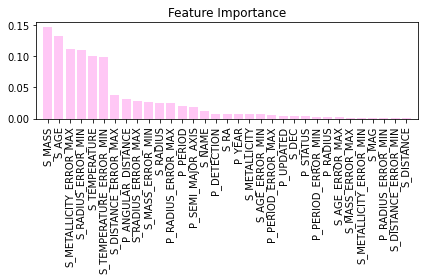

In [38]:
#Sets the column labels
feat_labels = df.columns[1:]

#Creates a Random Forest Classifier with 500 estimators. 
forest = RandomForestClassifier(n_estimators=500, random_state=1)

#Fits the Random Forest Classifier to the training data. 
forest.fit(X_train, y_train)
#Sets the importances of the features. 
importances = forest.feature_importances_

#Sets the indices relative to the importances. 
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  #Prints the importances and labels (in order of importance)
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
#Creates a bar chart depicting this data. 
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center',
        color="#ffc7f5")

#Plots the chart
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [40]:
#Creates the select from model object using the forest from above and 
#the desired threshold. 
sfm = SelectFromModel(forest, threshold=0.01, prefit=True)
#Gets the feature columns from the select from model object. 
X_selected_train = pd.DataFrame(sfm.transform(X_train))
X_selected_test = pd.DataFrame(sfm.transform(X_test))
#Creates dataframes from the selected train and test data.
A = pd.DataFrame(X_selected_train)
B = pd.DataFrame(X_selected_test)
#Sets the column names of these dataframes for viewability. 
features = X_train.loc[:, sfm.get_support()].columns
A.columns = features
B.columns = A.columns
#Prints the number of features that meet the threshold for the training and 
#testing data. 
print('Number of training features that meet this threshold criterion:', 
      X_selected_train.shape[1])
print('Number of test features that meet the threshold criteria: ',
      X_selected_test.shape[1])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of training features that meet this threshold criterion: 15
Number of test features that meet the threshold criteria:  15


In [41]:
A.head()

,P_PERIOD,P_DETECTION,S_DISTANCE,S_MASS,S_MASS_ERROR_MAX,S_TEMPERATURE,P_FLUX,P_TYPE,S_TYPE_TEMP,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_RADIUS_EST,P_MASS_EST
0,112.391312,8.000000,318.125225,0.537127,0.042143,4092.019026,0.888364,4.000000,4.571478,0.356091,1.0,1.000000,2.0,1.607834,3.215519
1,3.306539,8.000000,191.440000,1.003838,0.127335,3568.000000,27.310800,5.000000,5.000000,0.440103,0.0,0.000000,1.0,1.087370,1.312144
2,11.441859,7.000000,3.832440,0.091017,0.010721,2906.226918,0.397813,5.000000,5.000000,0.227119,1.0,0.994916,2.0,1.040765,1.120919
3,69.902358,8.000000,365.325501,0.734007,0.096629,4076.725743,0.950476,4.000000,4.535551,0.400505,1.0,0.535551,2.0,2.127612,5.254683
4,4.348705,7.652373,9.440406,0.083476,0.010000,2678.931405,1.209187,3.695255,5.000000,0.208495,1.0,0.000000,2.0,0.859704,0.632074


In [42]:
B.head()

,P_PERIOD,P_DETECTION,S_DISTANCE,S_MASS,S_MASS_ERROR_MAX,S_TEMPERATURE,P_FLUX,P_TYPE,S_TYPE_TEMP,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_RADIUS_EST,P_MASS_EST
0,6.033562,8.0,1204.000000,1.280000,0.010000,5047.000000,1339.669900,2.0,4.0,0.496640,0.0,0.000000,1.0,3.318160,11.001799
1,13.781300,8.0,66.990000,0.520000,0.060000,3841.000000,4.615616,5.0,5.0,0.370981,0.0,0.000000,1.0,1.199470,1.970534
2,3.388020,8.0,1057.360000,1.003838,0.127335,5551.000000,709.962210,4.0,3.0,0.440103,0.0,0.000000,1.0,2.152320,5.275878
3,33.298201,7.0,5.956693,0.318756,0.057039,3358.995278,0.950171,5.0,5.0,0.285319,1.0,0.718898,2.0,1.430943,2.640007
4,188.300000,7.0,97.510000,1.140000,0.150000,5601.000000,4.976123,0.0,3.0,0.481932,0.0,0.000000,1.0,13.101812,978.910250


## **Training**

In [44]:
#Creates a dictionary of all of the models I wanted to test
models = {
    "Logistic Regression": LogisticRegression(random_state=0, max_iter=10),
    "Decision Tree": tree.DecisionTreeClassifier(max_depth = 5),
    "Random Forest": RandomForestClassifier(n_estimators=5),
    "Support Vector": SVC(),
    "KNN": KNeighborsClassifier(),
    "SGD": SGDClassifier(),
    "Naive Bayes": GaussianNB()
  }

#Loops through the dictionary above. 
for name, model in models.items():
  model.fit(A, y_train) #Fits each model to the selected training data
  scores = cross_val_score(SGDClassifier(),A,y_train,cv=5) #Evaluates the model using cross validation based on an SGD Classifier
  print(name + " trained")
  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) #Prints the accuracy results. 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression trained
Accuracy: 0.51 (+/- 0.39)
Decision Tree trained
Accuracy: 0.52 (+/- 0.16)
Random Forest trained
Accuracy: 0.56 (+/- 0.21)
Support Vector trained
Accuracy: 0.52 (+/- 0.34)
KNN trained
Accuracy: 0.58 (+/- 0.21)
SGD trained
Accuracy: 0.55 (+/- 0.35)
Naive Bayes trained
Accuracy: 0.48 (+/- 0.31)


## **Model Comparison**

The following code blocks perform some grid search optimizations of a few different models to compare their performance. 

In [45]:
knn = KNeighborsClassifier() #Simple KNN classifier

In [46]:
k_range = list(range(1, 31)) #Range for the number of neighbors

#Defining the parameters for the grid search. 
grid_param_knn = {
    'n_neighbors': k_range,
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], #Algorithm options for KNN
    'p': [1, 2] #KNN distance metric parameter
}

gs_knn = GridSearchCV(estimator=knn, param_grid=grid_param_knn, scoring='accuracy', cv=5) #Performs the grid search
gs_knn.fit(A, y_train) #Fits the resulting classifier to the training data. 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'p': [1, 2]},
             scoring='accuracy')

In [47]:
best_parameters = gs_knn.best_params_ #Gets the best parameters from the grid search
print(best_parameters)

{'algorithm': 'auto', 'n_neighbors': 1, 'p': 1}


In [48]:
best_result = gs_knn.best_score_ #Scores the results of the grid search
print(best_result)

0.9695010739254858


In [49]:
classifier = RandomForestClassifier(n_estimators=300, random_state=0) #General random forest classifier

#Parameters to try for the random forest model
grid_param_rf = {
    'n_estimators': [100, 200, 500, 900],
    'bootstrap': [True, False],
    'random_state': [0, 1, 3]
}

#Performs the grid search given the parameters abov
gs = GridSearchCV(estimator=classifier,
                  param_grid=grid_param_rf,
                  scoring='accuracy',
                  cv=5)
gs.fit(A, y_train) #Fits the results to the training data
best_parameters = gs.best_params_ #Gets the best parameters
print(best_parameters)

{'bootstrap': True, 'n_estimators': 100, 'random_state': 0}


In [50]:
best_result = gs.best_score_ #Scores the grid search results
print(best_result)

1.0


In [52]:
#Verifies the grid search scores using cross validation

score_knn = cross_val_score(KNeighborsClassifier(**gs_knn.best_params_), A, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score_knn.mean(), score_knn.std() * 2))

scores = cross_val_score(RandomForestClassifier(**best_parameters),A,y_train,cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.00)
Accuracy: 1.00 (+/- 0.00)
